<a href="https://colab.research.google.com/github/Requenamar3/Data-Mining/blob/main/Data_Mining_Module2_Ecommerce_Kmeans%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementing KMeans Clustering for Customer Segmentation
Objective:
Apply the KMeans clustering technique to perform customer segmentation with a real-world dataset not provided in the lesson. This will involve sourcing a suitable dataset, conducting an exploratory data analysis, preprocessing the data, applying the KMeans clustering algorithm, and interpreting the results to gain insights into different customer segments.

**For this assigment will segment customers based on the frequency of their orders to identify loyal customers and those at risk of churn.**

#Dataset sourcing

In [55]:
import pandas as pd
# Import numpy for numerical computing.
import numpy as np
# Import datetime for handling dates and times.
import datetime as dt
# Import matplotlib.pyplot for creating static, animated, and interactive visualizations.
import matplotlib.pyplot as plt
# Import seaborn for making statistical graphics.
import seaborn as sns
# Import GammaGammaFitter from lifetimes for fitting the Gamma-Gamma model.
from lifetimes import GammaGammaFitter
# Import plot_frequency_recency_matrix for visualizing the relationship between frequency and recency.
from lifetimes.plotting import plot_frequency_recency_matrix
# Set pandas display options to improve the readability of output.
# Set the maximum number of rows to display to 500.
pd.set_option('display.max_rows', 500)
# Set the maximum number of columns to display to 500.
pd.set_option('display.max_columns', 500)
# Set the width of the display in characters to 1000.
pd.set_option('display.width', 1000)


In [56]:
#Import the ProfileReport .For creating comprehensive exploratory data analysis reports.
from ydata_profiling import ProfileReport

In [105]:
EC= pd.read_csv("https://raw.githubusercontent.com/Requenamar3/Data-Mining/main/sales_2023-10-01_2024-03-06.csv")

In [58]:
EC.head()

,month,financial_status,order_name,customer_email,customer_id,customer_type,variant_sku,product_price,product_title,shipping_region,shipping_postal_code,customer_cohort_week,customer_cohort_quarter,customer_cohort_month,product_type,total_sales,net_sales,total_cost,units_per_transaction
0,2023-10,paid,#805723,mayapriebe33@gmail.com,6616065245299,Returning,SQ9178530,0.00,Bloomsy Original (Ships every 1 Months),Colorado,80525,2023-W19,2023-04,2023-05,NaN,0.00,0.00,0.0,1
1,2023-10,partially_refunded,#810617,vincent.nicolais@yahoo.com,6261751251059,Returning,NaN,0.00,NaN,Georgia,31820,2022-W41,2022-10,2022-10,NaN,83.88,0.00,0.0,0
2,2023-10,partially_refunded,#810617,vincent.nicolais@yahoo.com,6261751251059,Returning,SQ8862610,642.99,Bloomsy Premium,Georgia,31820,2022-W41,2022-10,2022-10,NaN,694.43,642.99,0.0,1
3,2023-10,partially_refunded,#810431,cjsherrillmain@gmail.com,3496267448435,Returning,SQ1726938,69.99,Bloomsy Deluxe,Maryland,20636,2020-W48,2020-10,2020-11,NaN,74.19,69.99,0.0,1
4,2023-10,partially_refunded,#810431,cjsherrillmain@gmail.com,3496267448435,Returning,NaN,0.00,NaN,Maryland,20636,2020-W48,2020-10,2020-11,NaN,-10.60,-10.60,0.0,0


In [59]:
EC.columns

Index(['month', 'financial_status', 'order_name', 'customer_email', 'customer_id', 'customer_type', 'variant_sku', 'product_price', 'product_title', 'shipping_region', 'shipping_postal_code', 'customer_cohort_week', 'customer_cohort_quarter', 'customer_cohort_month', 'product_type', 'total_sales', 'net_sales', 'total_cost', 'units_per_transaction'], dtype='object')

In [106]:
EC= pd.read_csv("https://raw.githubusercontent.com/Requenamar3/Data-Mining/main/sales_2023-10-01_2024-03-06.csv",usecols=['customer_id', 'order_name','variant_sku','month', 'customer_cohort_month', 'total_sales', 'units_per_transaction'])

In [107]:
EC.head()


,month,order_name,customer_id,variant_sku,customer_cohort_month,total_sales,units_per_transaction
0,2023-10,#805723,6616065245299,SQ9178530,2023-05,0.00,1
1,2023-10,#810617,6261751251059,NaN,2022-10,83.88,0
2,2023-10,#810617,6261751251059,SQ8862610,2022-10,694.43,1
3,2023-10,#810431,3496267448435,SQ1726938,2020-11,74.19,1
4,2023-10,#810431,3496267448435,NaN,2020-11,-10.60,0


#Exploratory Data Analysis

In [108]:
# Create a ProfileReport object
profile = ProfileReport(EC, title="EC CLV", explorative=True)

In [63]:
# display report
profile


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Remove records with 0 values on sales or transactions as these could be possible cancelations



In [109]:
# Remove rows from 'EC' where 'total_sales' is equal to 0.00
EC = EC[EC['total_sales'] != 0.00]


In [110]:
# Remove records with 0 orders qty
EC = EC[EC['units_per_transaction'] != 0]


In [111]:
EC.head()

,month,order_name,customer_id,variant_sku,customer_cohort_month,total_sales,units_per_transaction
2,2023-10,#810617,6261751251059,SQ8862610,2022-10,694.43,1
3,2023-10,#810431,3496267448435,SQ1726938,2020-11,74.19,1
8,2023-10,#802622,5601422671987,BB738-24,2022-03,54.49,1
11,2023-10,#801731,6769237557363,BB727-26,2023-07,64.34,1
13,2023-10,#807669,6272794919027,BB944-24,2022-10,63.74,1


In [112]:
EC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44231 entries, 2 to 158180
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   month                  44231 non-null  object 
 1   order_name             44231 non-null  object 
 2   customer_id            44231 non-null  int64  
 3   variant_sku            44214 non-null  object 
 4   customer_cohort_month  44231 non-null  object 
 5   total_sales            44231 non-null  float64
 6   units_per_transaction  44231 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 3.7+ MB


Remove records with missing Variant_skus (coupons)

In [113]:
EC.isnull().sum()

month                     0
order_name                0
customer_id               0
variant_sku              17
customer_cohort_month     0
total_sales               0
units_per_transaction     0
dtype: int64

In [114]:
EC.dropna(inplace=True)  # inplace=True means we dropped them permanently

In [115]:
EC.isnull().sum()

month                    0
order_name               0
customer_id              0
variant_sku              0
customer_cohort_month    0
total_sales              0
units_per_transaction    0
dtype: int64

In [116]:
EC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44214 entries, 2 to 158180
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   month                  44214 non-null  object 
 1   order_name             44214 non-null  object 
 2   customer_id            44214 non-null  int64  
 3   variant_sku            44214 non-null  object 
 4   customer_cohort_month  44214 non-null  object 
 5   total_sales            44214 non-null  float64
 6   units_per_transaction  44214 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 2.7+ MB


In [72]:
EC.describe()

,customer_id,total_sales,units_per_transaction
count,4.421400e+04,44214.000000,44214.000000
mean,5.562729e+12,117.220923,1.005406
std,1.682923e+12,149.469024,0.084234
min,1.183560e+12,0.220000,1.000000
25%,5.028425e+12,49.530000,1.000000
50%,6.368478e+12,59.600000,1.000000
75%,6.996533e+12,84.790000,1.000000
max,7.301131e+12,3507.540000,5.000000


#Data Preprocessing

I capped the data by setting outliers to the boundary values. This reduces the impact of very extreme values when conducting statistical analyses or building machine learning models

In [117]:
def find_boundaries(df, variable,q1=0.05,q2=0.95):
    # the boundaries are the quantiles
    lower_boundary = df[variable].quantile(q1) # lower quantile
    upper_boundary = df[variable].quantile(q2) # upper quantile
    return upper_boundary, lower_boundary
def capping_outliers(df,variable):
    upper_boundary,lower_boundary =  find_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                       np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

In [118]:
# Function to cap outliers in the 'Total_sales'
capping_outliers(EC, 'total_sales')

# Function to cap outliers in the 'units_per_transaction'
capping_outliers(EC, 'units_per_transaction')


In [119]:
EC.describe()

,customer_id,total_sales,units_per_transaction
count,4.421400e+04,44214.000000,44214.0
mean,5.562729e+12,109.982135,1.0
std,1.682923e+12,118.461722,0.0
min,1.183560e+12,42.790000,1.0
25%,5.028425e+12,49.530000,1.0
50%,6.368478e+12,59.600000,1.0
75%,6.996533e+12,84.790000,1.0
max,7.301131e+12,498.934000,1.0


In [120]:
#add new column and Convert 'month' to datetime format, assuming the first day of the month.
EC['month_date'] = pd.to_datetime(EC['month'], format='%Y-%m')

# add new column and Convert 'customer_cohort_month' to datetime format, assuming the first day of the month.
EC['customer_cohort_date'] = pd.to_datetime(EC['customer_cohort_month'], format='%Y-%m')


In [121]:
#remove the 'month' and 'customer_cohort_month' columns
EC.drop(['month', 'customer_cohort_month'], axis=1, inplace=True)

EC.head()

,order_name,customer_id,variant_sku,total_sales,units_per_transaction,month_date,customer_cohort_date
2,#810617,6261751251059,SQ8862610,498.934,1.0,2023-10-01,2022-10-01
3,#810431,3496267448435,SQ1726938,74.190,1.0,2023-10-01,2020-11-01
8,#802622,5601422671987,BB738-24,54.490,1.0,2023-10-01,2022-03-01
11,#801731,6769237557363,BB727-26,64.340,1.0,2023-10-01,2023-07-01
13,#807669,6272794919027,BB944-24,63.740,1.0,2023-10-01,2022-10-01


#Applying the Elbow Method

 For the assigment I need to create a feature that represents the frequency of purchases by each customer.

In [122]:
# Group by customer_id and count the number of orders.
frequency_EC = EC.groupby('customer_id')['order_name'].count().reset_index()

# Rename the columns for clarity.
frequency_EC.columns = ['customer_id', 'purchase_frequency']

# You can now merge this back with your original DataFrame if you need to maintain all data.
EC = pd.merge(EC, frequency_EC, on='customer_id')


In [123]:
EC.head()

,order_name,customer_id,variant_sku,total_sales,units_per_transaction,month_date,customer_cohort_date,purchase_frequency
0,#810617,6261751251059,SQ8862610,498.934,1.0,2023-10-01,2022-10-01,1
1,#810431,3496267448435,SQ1726938,74.190,1.0,2023-10-01,2020-11-01,10
2,#802622,5601422671987,BB738-24,54.490,1.0,2023-10-01,2022-03-01,4
3,#801731,6769237557363,BB727-26,64.340,1.0,2023-10-01,2023-07-01,1
4,#807669,6272794919027,BB944-24,63.740,1.0,2023-10-01,2022-10-01,4


In [124]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale the 'purchase_frequency' column
scaler = StandardScaler()
EC_scaled = scaler.fit_transform(EC[['purchase_frequency']])

In [125]:
# Apply the Elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):  # testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(EC_scaled)
    wcss.append(kmeans.inertia_)


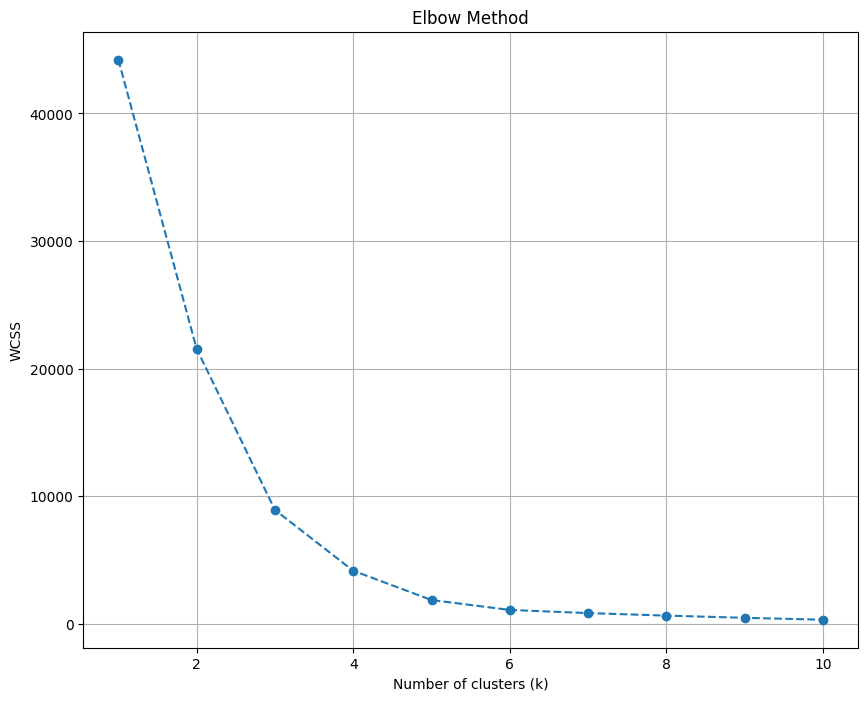

In [126]:
# Plotting the results onto a line graph to observe 'The elbow'
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


#KMeans Clustering

In [127]:
# Identified number of clusters from the elbow method
k = 3

# Implement KMeans with the identified number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model
kmeans.fit(EC_scaled)

# Predict the clusters
clusters = kmeans.predict(EC_scaled)

# Append the cluster predictions to the original dataframe
EC['cluster'] = clusters

# Display the dataframe with the clusters
EC.head()


,order_name,customer_id,variant_sku,total_sales,units_per_transaction,month_date,customer_cohort_date,purchase_frequency,cluster
0,#810617,6261751251059,SQ8862610,498.934,1.0,2023-10-01,2022-10-01,1,0
1,#810431,3496267448435,SQ1726938,74.190,1.0,2023-10-01,2020-11-01,10,2
2,#802622,5601422671987,BB738-24,54.490,1.0,2023-10-01,2022-03-01,4,0
3,#801731,6769237557363,BB727-26,64.340,1.0,2023-10-01,2023-07-01,1,0
4,#807669,6272794919027,BB944-24,63.740,1.0,2023-10-01,2022-10-01,4,0


#Analyzing and Visualizing the Clusters

Calculate the mean values of the features for each cluster.

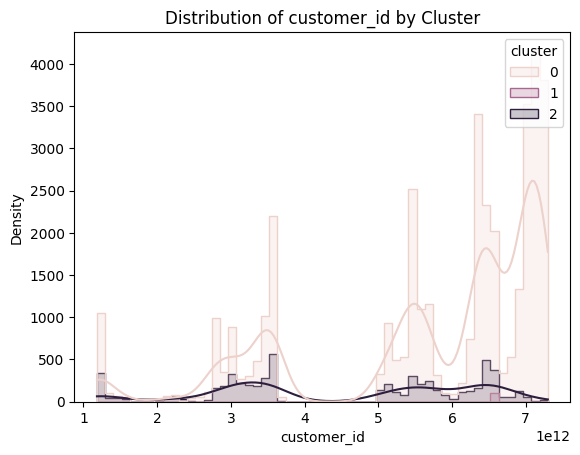

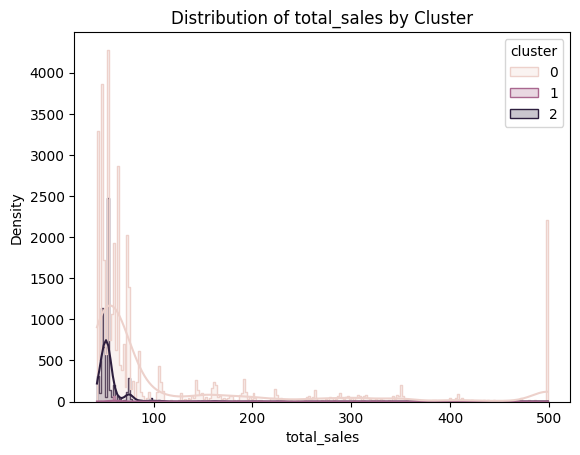

LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

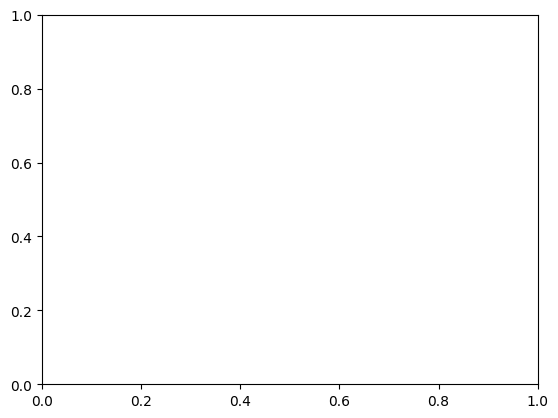

In [129]:
# Identify numeric columns for mean calculation
numeric_columns = EC.select_dtypes(include=[np.number]).columns.tolist()

# Calculate mean values of the numeric features for each cluster.
cluster_means = EC.groupby('cluster')[numeric_columns].mean()

# Create visual plots for the distribution of numeric features within each cluster.
for column in numeric_columns:
    sns.histplot(data=EC, x=column, hue='cluster', element='step', kde=True)
    plt.title(f'Distribution of {column} by Cluster')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.show()


In [87]:
# Inverse transform the centroids to the original scale
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
print("Centroids in the original 'purchase_frequency' scale:")
print(centroids)

Centroids in the original 'purchase_frequency' scale:
[[  3.39390289]
 [101.        ]
 [ 15.67475974]]


In [88]:
# Look at the distribution of customers over the clusters
cluster_distribution = EC['cluster'].value_counts()
print("Cluster distribution:")
print(cluster_distribution)

Cluster distribution:
cluster
0    38182
2     5931
1      101
Name: count, dtype: int64


In [89]:
print(EC.head())

     month order_name    customer_id variant_sku customer_cohort_month  total_sales  units_per_transaction  purchase_frequency month_date customer_cohort_date  cluster
0  2023-10    #810617  6261751251059   SQ8862610               2022-10      498.934                    1.0                   1 2023-10-01           2022-10-01        0
1  2023-10    #810431  3496267448435   SQ1726938               2020-11       74.190                    1.0                  10 2023-10-01           2020-11-01        2
2  2023-10    #802622  5601422671987    BB738-24               2022-03       54.490                    1.0                   4 2023-10-01           2022-03-01        0
3  2023-10    #801731  6769237557363    BB727-26               2023-07       64.340                    1.0                   1 2023-10-01           2023-07-01        0
4  2023-10    #807669  6272794919027    BB944-24               2022-10       63.740                    1.0                   4 2023-10-01           2022-10-01  

In [90]:
# For instance, assuming cluster 0 is 'loyal', 1 is 'new', and 2 is 'at risk'
cluster_labels = {
    0: 'loyal',
    1: 'new',
    2: 'at risk'
}
EC['cluster_label'] = EC['cluster'].map(cluster_labels)
print(EC[['customer_id', 'purchase_frequency', 'cluster', 'cluster_label']].head())

     customer_id  purchase_frequency  cluster cluster_label
0  6261751251059                   1        0         loyal
1  3496267448435                  10        2       at risk
2  5601422671987                   4        0         loyal
3  6769237557363                   1        0         loyal
4  6272794919027                   4        0         loyal
